In [20]:
import math
# import nltk
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score




In [21]:
df = pd.read_csv("preprocessed.csv", sep=",")

In [22]:
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,fare_amount,pickup_zipcode,dropoff_zipcode,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_time
0,2018-06-01 00:33:55,2018-06-01 00:36:13,5,0.51,4.0,11201.0,11201.0,1,0,4,6,2018,138
1,2018-06-01 00:40:36,2018-06-01 00:49:46,5,1.97,9.0,11201.0,11205.0,1,0,4,6,2018,550
2,2018-06-01 00:57:12,2018-06-01 01:02:58,5,1.40,6.5,11238.0,11205.0,1,0,4,6,2018,346
3,2018-06-01 00:10:13,2018-06-01 00:16:27,1,1.36,7.0,11205.0,11205.0,1,0,4,6,2018,374
4,2018-06-01 00:32:08,2018-06-01 00:52:06,1,7.90,24.0,10029.0,10034.0,1,0,4,6,2018,1198


In [23]:
cols = ['trip_distance', 'pickup_zipcode', 'dropoff_zipcode',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'pickup_year', 'trip_time', 'passenger_count', 'fare_amount']

In [24]:
df = df[cols]

In [25]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [26]:
df = MultiColumnLabelEncoder(columns = ['pickup_zipcode','dropoff_zipcode', 'pickup_year', ]).fit_transform(df)

In [27]:
df.head()

,trip_distance,pickup_zipcode,dropoff_zipcode,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_time,passenger_count,fare_amount
0,0.51,61,73,1,0,4,6,1,138,5,4.0
1,1.97,61,75,1,0,4,6,1,550,5,9.0
2,1.40,89,75,1,0,4,6,1,346,5,6.5
3,1.36,63,75,1,0,4,6,1,374,1,7.0
4,7.90,20,27,1,0,4,6,1,1198,1,24.0


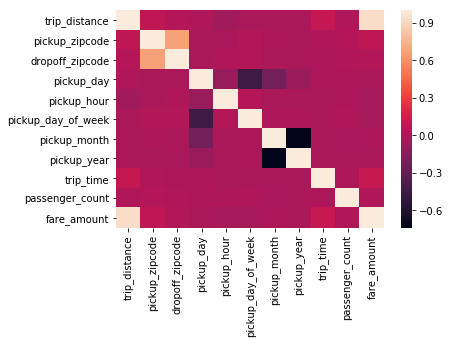

In [28]:
sns.heatmap(df.corr())
plt.show()

In [29]:
def standardize_data(df, features):
    sc = StandardScaler()
    temp = sc.fit_transform(df[features])
    df[features] = temp
    return df, sc

In [30]:
features = ['trip_distance', 'pickup_zipcode', 'dropoff_zipcode',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'pickup_year', 'trip_time', 'passenger_count']

In [31]:
scaled_df, sc = standardize_data(df.copy(), features)

In [32]:
scaled_df.head()

,trip_distance,pickup_zipcode,dropoff_zipcode,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_time,passenger_count,fare_amount
0,-0.755122,0.087357,0.177771,-1.135998,-2.146029,0.032245,0.009418,0.003188,-0.202536,3.505170,4.0
1,-0.360765,0.087357,0.225834,-1.135998,-2.146029,0.032245,0.009418,0.003188,-0.135949,3.505170,9.0
2,-0.514726,0.917470,0.225834,-1.135998,-2.146029,0.032245,0.009418,0.003188,-0.168919,3.505170,6.5
3,-0.525530,0.146651,0.225834,-1.135998,-2.146029,0.032245,0.009418,0.003188,-0.164394,-0.350011,7.0
4,1.240973,-1.128166,-0.927660,-1.135998,-2.146029,0.032245,0.009418,0.003188,-0.031220,-0.350011,24.0


In [33]:
# pca = PCA(n_components=7)
# df_pca = pca.fit_transform(scaled_df[features])

In [74]:
train_x, test_x, train_y, test_y = train_test_split(scaled_df[features], scaled_df['fare_amount'], test_size=0, shuffle=True)


In [75]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(98395, 10)
(98395,)
(0, 10)
(0,)


In [70]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_x, train_y)
rf_predict = rf.predict(test_x)

In [71]:
rf_predict[:5]

array([ 9.85,  8.75,  8.65,  8.95, 12.85])

In [72]:
test_y.head()

17436    10.5
38964     8.5
76842     8.5
72188     9.5
41826    12.5
Name: fare_amount, dtype: float64

KNN
[CV]  ................................................................
[CV] ................................................. , total=  17.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s


[CV] ................................................. , total=  17.3s
[CV]  ................................................................
[CV] ................................................. , total=  11.1s
[CV]  ................................................................
[CV] ................................................. , total=  16.9s
[CV]  ................................................................
[CV] ................................................. , total=  17.7s
KNN: -0.159650 (0.310698)
LR
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ..........................................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
DT: -0.508229 (0.282003)
RF
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


[CV] ................................................. , total=  24.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s


[CV] ................................................. , total=  24.3s
[CV]  ................................................................
[CV] ................................................. , total=  23.8s
[CV]  ................................................................
[CV] ................................................. , total=  24.5s
[CV]  ................................................................
[CV] ................................................. , total=  24.6s
RF: -0.472289 (0.324979)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


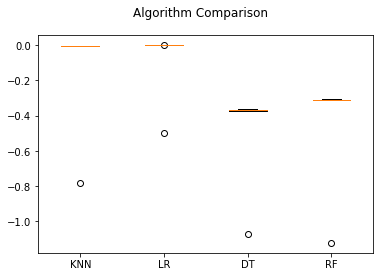

In [77]:
# def perform_grid_search(train_x, train_y):
seed = 7
# prepare models
models = []

regressors = [
    ('KNN', KNeighborsRegressor(3)),
    ('LR', LinearRegression()),
    ('DT', DecisionTreeRegressor(max_depth=5)),
    ('RF', RandomForestRegressor(max_depth=5, n_estimators=200, max_features='auto'))
    ]
# evaluate each model in turn
results = []
names = []
#     scoring = 'neg_mean_absolute_error'
scoring = 'neg_mean_squared_error'
for name, model in regressors:
    print(name)
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, train_x, train_x, cv=kfold, scoring=scoring, verbose=2)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

KNN
[CV]  ................................................................
[CV] ................................................. , total=  16.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s remaining:    0.0s


[CV] ................................................. , total=  15.9s
[CV]  ................................................................
[CV] ................................................. , total=  16.0s
[CV]  ................................................................
[CV] ................................................. , total=  10.8s
[CV]  ................................................................
[CV] ................................................. , total=  15.9s
KNN: -0.022832 (0.001312)
LR
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ..........................................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
DT: -0.348232 (0.012437)
RF
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


[CV] ................................................. , total=  24.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s


[CV] ................................................. , total=  24.5s
[CV]  ................................................................
[CV] ................................................. , total=  24.4s
[CV]  ................................................................
[CV] ................................................. , total=  23.8s
[CV]  ................................................................
[CV] ................................................. , total=  24.4s
RF: -0.327989 (0.004762)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


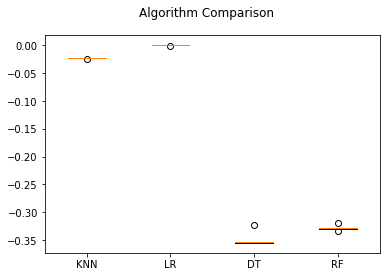

In [62]:
# perform_grid_search(train_x, train_y)